#### Aim: To build a predictive model to determine which patients will be readmitted to the hospital within 30 days.

#### Importing Libraries

In [2]:
!pip install feature_engine

import warnings 
warnings.filterwarnings('ignore')
import re
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import roc_auc_score, roc_curve, auc,accuracy_score,classification_report


#### Load Data

In [3]:
df1 = pd.read_csv('C:/Users/ANKIT/Desktop/AbleTo_DS_take_home_modeling/data.csv')

In [4]:
df1.head()

,patient_ID,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change_of_medication,medication,readmitted
0,225348,Caucasian,Female,[20-30),NaN,1,6,3,1,NaN,...,No,No,No,No,No,No,No,No,No,NO
1,610034,Caucasian,Female,[50-60),NaN,3,18,4,2,NaN,...,No,No,No,No,No,No,No,Ch,Yes,NO
2,137883,Caucasian,Male,[30-40),NaN,6,1,17,2,NaN,...,No,Down,No,No,No,No,No,Ch,Yes,NO
3,852003,Caucasian,Male,[30-40),NaN,2,1,7,5,SP,...,No,No,No,No,No,No,No,No,Yes,NO
4,339551,Caucasian,Female,[80-90),NaN,5,3,1,4,MC,...,No,No,No,No,No,No,No,No,Yes,YES


In [5]:
df2 = pd.read_csv('C:/Users/ANKIT/Desktop/AbleTo_DS_take_home_modeling/icd_to_ccs_mapping.csv')

In [6]:
df2.head()

,icd,ccs,ccs_desc,icd_desc
0,010,1,Tuberculosis,PRIM TB COMPLEX-UNSPEC
1,011,1,Tuberculosis,TB LUNG INFILTR-UNSPEC
2,012,1,Tuberculosis,TB PLEURISY-UNSPEC
3,013,1,Tuberculosis,TB MENINGITIS-UNSPEC
4,014,1,Tuberculosis,TB PERITONITIS-UNSPEC


In [7]:
df2 = df2.groupby('ccs')

In [8]:
for ccs, ccs_df in df2:
    print(ccs)
    print(ccs_df)

1
    icd  ccs      ccs_desc                      icd_desc
0   010    1  Tuberculosis        PRIM TB COMPLEX-UNSPEC
1   011    1  Tuberculosis        TB LUNG INFILTR-UNSPEC
2   012    1  Tuberculosis            TB PLEURISY-UNSPEC
3   013    1  Tuberculosis          TB MENINGITIS-UNSPEC
4   014    1  Tuberculosis         TB PERITONITIS-UNSPEC
5   015    1  Tuberculosis         TB OF VERTEBRA-UNSPEC
6   016    1  Tuberculosis           TB OF KIDNEY-UNSPEC
7   017    1  Tuberculosis       TB SKIN/SUBCUTAN-UNSPEC
8   018    1  Tuberculosis       ACUTE MILIARY TB-UNSPEC
9   137    1  Tuberculosis      LATE EFFECT TB- RESP/NOS
10  V12    1  Tuberculosis  HX TUBERCULOSIS (Begin 1994)
2
    icd  ccs    ccs_desc                               icd_desc
11  003    2  Septicemia                  SALMONELLA SEPTICEMIA
12  020    2  Septicemia                      SEPTICEMIC PLAGUE
13  022    2  Septicemia                     ANTHRAX SEPTICEMIA
14  036    2  Septicemia                        MENINGOC

433  414  101  Coron athero  CORONARY ATHEROSCLEROSIS (End 1994)
102
     icd  ccs    ccs_desc        icd_desc
434  786  102  Chest pain  CHEST PAIN NOS
103
     icd  ccs      ccs_desc                  icd_desc
435  415  103  Pulm hart dx       ACUTE COR PULMONALE
436  416  103  Pulm hart dx    PRIM PULM HYPERTENSION
437  417  103  Pulm hart dx  ARTERIOVEN FISTU PUL VES
105
     icd  ccs    ccs_desc                  icd_desc
438  426  105  Conduction  ATRIOVENT BLOCK COMPLETE
106
     icd  ccs     ccs_desc                  icd_desc
439  427  106  Dysrhythmia  PAROX ATRIAL TACHYCARDIA
108
     icd  ccs   ccs_desc                  icd_desc
440  428  108  chf;nonhp  CONGESTIVE HEART FAILURE
109
     icd  ccs   ccs_desc                                         icd_desc
441  430  109  Acute CVD                          SUBARACHNOID HEMORRHAGE
442  431  109  Acute CVD                         INTRACEREBRAL HEMORRHAGE
443  432  109  Acute CVD                          NONTRAUM EXTRADURAL HEM
444

710  720  202  Rheum arth  ANKYLOSING SPONDYLITIS
203
     icd  ccs      ccs_desc                icd_desc
711  715  203  Osteoarthros  GENERAL OSTEOARTHROSIS
204
     icd  ccs     ccs_desc                  icd_desc
712  713  204  Ot joint dx  ARTHROP W ENDOCR/MET DIS
713  716  204  Ot joint dx   KASCHIN-BECK DIS-UNSPEC
714  718  204  Ot joint dx         LOOSE BODY-UNSPEC
715  719  204  Ot joint dx     JOINT EFFUSION-UNSPEC
205
     icd  ccs      ccs_desc                  icd_desc
716  721  205  Back problem      CERVICAL SPONDYLOSIS
717  722  205  Back problem  CERVICAL DISC DISPLACMNT
718  723  205  Back problem  CERVICAL SPINAL STENOSIS
719  724  205  Back problem       SPINAL STENOSIS NOS
206
     icd  ccs      ccs_desc          icd_desc
720  733  206  Osteoporosis  OSTEOPOROSIS NOS
208
     icd  ccs      ccs_desc                icd_desc
721  727  208  Acq foot def                  BUNION
722  734  208  Acq foot def               FLAT FOOT
723  735  208  Acq foot def           HALLU

In [9]:
df1.head().T

,0,1,2,3,4
patient_ID,225348,610034,137883,852003,339551
race,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Male,Male,Female
age,[20-30),[50-60),[30-40),[30-40),[80-90)
weight,NaN,NaN,NaN,NaN,NaN
admission_type_id,1,3,6,2,5
discharge_disposition_id,6,18,1,1,3
admission_source_id,3,4,17,7,1
time_in_hospital,1,2,2,5,4
payer_code,NaN,NaN,NaN,SP,MC


In [10]:
# check the shape
df1.shape

(101766, 49)

In [11]:
# check the data types
df1.dtypes

patient_ID                   int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
num_outpatient               int64
num_emergency                int64
num_inpatient                int64
diag_1                      object
diag_2                      object
diag_3                      object
num_diagnoses                int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide       

In [12]:
# check if there are some missing values
df1.isnull().sum()

patient_ID                      0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
num_outpatient                  0
num_emergency                   0
num_inpatient                   0
diag_1                         21
diag_2                        358
diag_3                       1423
num_diagnoses                   0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide     

#### Data Cleaning

In [13]:
for column in df1.columns:                           
    print(column)                                     
    print(df1[column].unique())                      
    print('\n')  

patient_ID
[225348 610034 137883 ... 349847 236862 842531]


race
['Caucasian' 'AfricanAmerican' 'Hispanic' 'Other' nan 'Asian']


gender
['Female' 'Male' 'Unknown/Invalid']


age
['[20-30)' '[50-60)' '[30-40)' '[80-90)' '[60-70)' '[70-80)' '[40-50)'
 '[90-100)' '[10-20)' '[0-10)']


weight
[nan '[75-100)' '[50-75)' '[100-125)' '[125-150)' '[25-50)' '[150-175)'
 '[0-25)' '[175-200)' '>200']


admission_type_id
[1 3 6 2 5 8 7 4]


discharge_disposition_id
[ 6 18  1  3  2 11 13 23  5 25 14  7  4 22 28 10  8 24 27 16 15  9 17 19
 12 20]


admission_source_id
[ 3  4 17  7  1  6 20  9  2  5  8 22 10 13 14 25 11]


time_in_hospital
[ 1  2  5  4  3  6  8  9  7 11 10 13 14 12]


payer_code
[nan 'SP' 'MC' 'MD' 'BC' 'CP' 'HM' 'DM' 'CM' 'OG' 'UN' 'CH' 'MP' 'OT' 'PO'
 'WC' 'SI' 'FR']


medical_specialty
[nan 'Family/GeneralPractice' 'InternalMedicine' 'Cardiology'
 'Emergency/Trauma' 'Orthopedics-Reconstructive' 'Surgery-General'
 'Radiologist' 'Surgery-Neuro' 'Nephrology' 'Urology' 'Pulmonology'


In [14]:
# drop columns which doesn't add any value to data
df1.drop(['weight','payer_code','medical_specialty','examide','citoglipton'],axis=1,inplace=True)

In [15]:
meds = ['change_of_medication','medication','metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

In [16]:
df1['race'] = df1['race'].replace({np.nan: 'Missing'})
df1['gender'] = df1['gender'].replace('Male', 1)
df1['gender'] = df1['gender'].replace('Female', 0)
df1['gender'] = df1['gender'].replace('Unknown/Invalid', 2)
df1['A1Cresult'] = df1['A1Cresult'].replace('>7', 1)
df1['A1Cresult'] = df1['A1Cresult'].replace('>8', 1)
df1['A1Cresult'] = df1['A1Cresult'].replace('Norm', 0)
df1['A1Cresult'] = df1['A1Cresult'].replace('None', -99)
df1['max_glu_serum'] = df1['max_glu_serum'].replace('>200', 1)
df1['max_glu_serum'] = df1['max_glu_serum'].replace('>300', 1)
df1['max_glu_serum'] = df1['max_glu_serum'].replace('Norm', 0)
df1['max_glu_serum'] = df1['max_glu_serum'].replace('None', -99)
df1['readmitted'] = df1['readmitted'].replace('NO', 0)
df1['readmitted'] = df1['readmitted'].replace('YES', 1)
for col in meds:
    df1[col] = df1[col].replace('No', 0)
    df1[col] = df1[col].replace('Ch',1)
    df1[col] = df1[col].replace('Yes', 1)
    df1[col] = df1[col].replace('Steady', 1)
    df1[col] = df1[col].replace('Up', 1)
    df1[col] = df1[col].replace('Down', 1)

In [17]:
# Age cleanning
df1.age.value_counts()
labels = df1['age'].astype('category').cat.categories.tolist()
replace_age = {'age' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
df1.replace(replace_age, inplace=True)

In [18]:
diag_list = ['diag_1','diag_2','diag_3']
for col in diag_list:
    df1[col].fillna('0', inplace=True)

In [19]:
def transform_func(value):
    value = re.sub("V[0-9]*", '0', value) 
    value = re.sub("E[0-9]*", '0', value)
    return value

def transform_category(value):
    if value>=390 and value<=459 or value==785:
        category = 1
    elif value>=460 and value<=519 or value==786:
        category = 2
    elif value>=520 and value<=579 or value==787:
        category = 3
    elif value==250:
        category = 4
    elif value>=800 and value<=999:
        category = 5          
    elif value>=710 and value<=739:
        category = 6   
    elif value>=580 and value<=629 or value==788:
        category = 7
    elif value>=140 and value<=239 :
        category = 8
    else :
        category = 0

    return category

In [20]:
for col in diag_list:
    df1[col] = df1[col].apply(transform_func)
    df1[col] = df1[col].astype(float)
    df1[col] = df1[col].apply(transform_category)

In [21]:
# correlation between differnet variables
corr = df1.corr()
corr

,patient_ID,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change_of_medication,medication,readmitted
patient_ID,1.000000,0.000960,-0.002279,0.004303,0.001214,0.001411,-0.001129,0.000982,0.005753,0.004805,...,-0.000835,0.000924,0.000935,0.000754,0.001027,-0.004282,-0.001686,0.002203,0.002307,-0.002929
gender,0.000960,1.000000,-0.050535,0.014592,-0.020847,-0.003843,-0.029928,-0.003103,0.059980,-0.022023,...,0.007012,0.000907,0.003684,0.006954,-0.002907,0.004779,-0.002907,0.014905,0.015901,-0.002939
age,-0.002279,-0.050535,1.000000,-0.007209,0.114323,0.044696,0.107515,0.020770,-0.030104,0.041847,...,0.005111,-0.087432,-0.001506,0.002042,-0.000190,0.002512,-0.000190,-0.036019,-0.022601,0.017634
admission_type_id,0.004303,0.014592,-0.007209,1.000000,0.083483,0.106654,-0.012500,-0.143713,0.129888,0.079535,...,0.008706,-0.031504,-0.003272,-0.004399,-0.002221,-0.000074,0.002117,0.007274,-0.000310,-0.011651
discharge_disposition_id,0.001214,-0.020847,0.114323,0.083483,1.000000,0.018193,0.162748,0.023415,0.015921,0.108753,...,0.008186,-0.046635,-0.004490,0.000444,-0.001612,-0.000181,-0.000425,-0.012307,-0.028887,0.050560
admission_source_id,0.001411,-0.003843,0.044696,0.106654,0.018193,1.000000,-0.006965,0.048885,-0.135400,-0.054533,...,0.001801,0.012654,-0.024197,-0.000387,0.000961,-0.001914,-0.003667,0.002435,0.001500,0.005820
time_in_hospital,-0.001129,-0.029928,0.107515,-0.012500,0.162748,-0.006965,1.000000,0.318450,0.191472,0.466135,...,-0.003102,0.099043,-0.002164,-0.000626,-0.002516,-0.000588,0.001684,0.109173,0.062520,0.044199
num_lab_procedures,0.000982,-0.003103,0.020770,-0.143713,0.023415,0.048885,0.318450,1.000000,0.058066,0.268161,...,-0.000606,0.093417,-0.011003,-0.007524,-0.000812,0.001218,-0.003202,0.063958,0.033107,0.020364
num_procedures,0.005753,0.059980,-0.030104,0.129888,0.015921,-0.135400,0.191472,0.058066,1.000000,0.385767,...,0.002281,0.015630,-0.001239,-0.005309,-0.002462,0.004315,-0.000624,0.004448,-0.006821,-0.012227
num_medications,0.004805,-0.022023,0.041847,0.079535,0.108753,-0.054533,0.466135,0.268161,0.385767,1.000000,...,-0.002894,0.208174,0.009010,0.003500,-0.003480,0.007897,0.001534,0.246846,0.186910,0.038432


#### Data Visualization

Text(0.5, 1.0, 'Distribution of Readmitted')

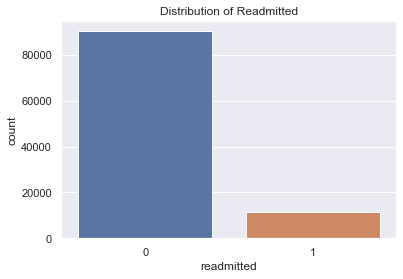

In [22]:
# Distribution of Readmitted it shows that target is imbalanced
sns.countplot(df1['readmitted']).set_title('Distribution of Readmitted')

Text(0.5, 1.0, 'Time in Hospital Vs Readmission To Hospital')

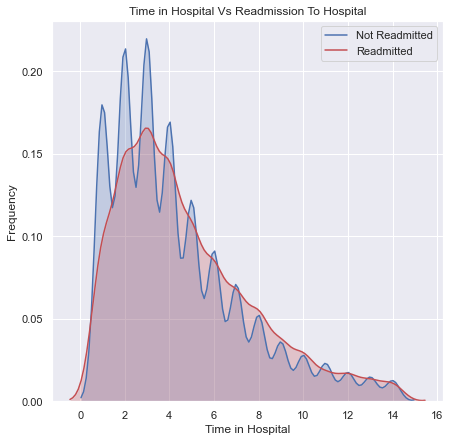

In [23]:
# Time in Hospital Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7),)
ax=sns.kdeplot(df1.loc[(df1['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(df1.loc[(df1['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital Vs Readmission To Hospital')

Text(0.5, 1.0, 'Age of Patient Vs Readmission To Hospital')

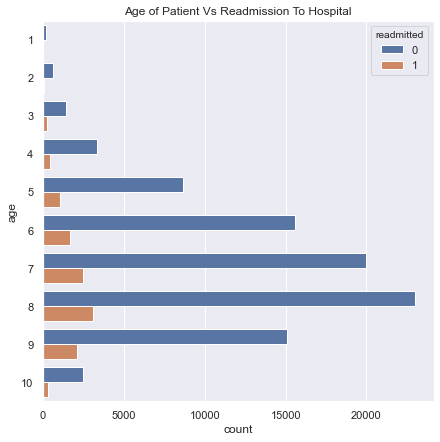

In [24]:
# Age of Patient Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['age'], hue = df1['readmitted']).set_title('Age of Patient Vs Readmission To Hospital')

Text(0.5, 1.0, 'Race Vs Readmission To Hospital')

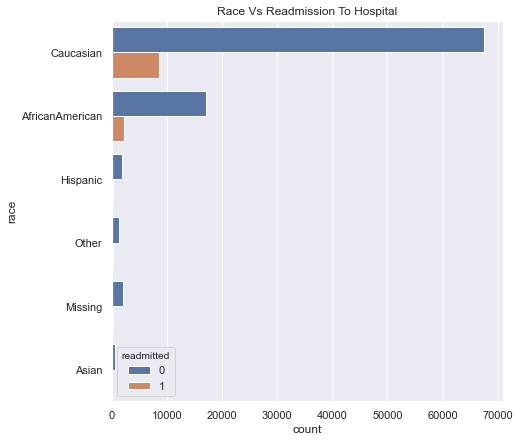

In [25]:
# Race Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y = df1['race'], hue = df1['readmitted']).set_title('Race Vs Readmission To Hospital')

Text(0.5, 1.0, 'Number of Medications sed Vs Readmission To Hospital')

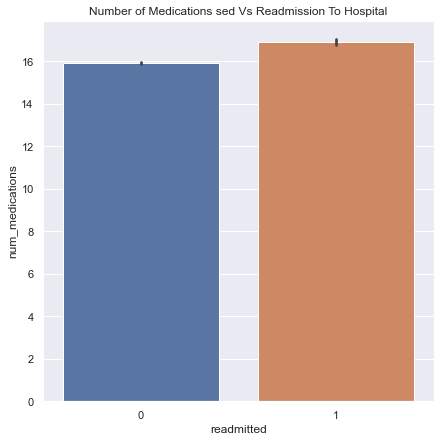

In [26]:
# Number of Medications sed Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.barplot(x = df1['readmitted'], y = df1['num_medications']).set_title("Number of Medications sed Vs Readmission To Hospital")

Text(0.5, 1.0, 'Gender of Patient Vs Readmission To Hospital')

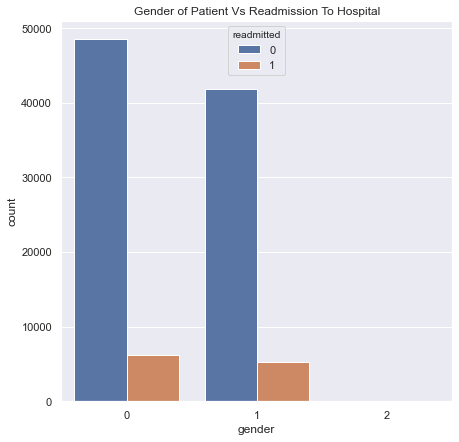

In [27]:
# Gender of Patient Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(df1['gender'], hue = df1['readmitted']).set_title("Gender of Patient Vs Readmission To Hospital")

Text(0.5, 1.0, 'Change of Medication Vs Readmission To Hospital')

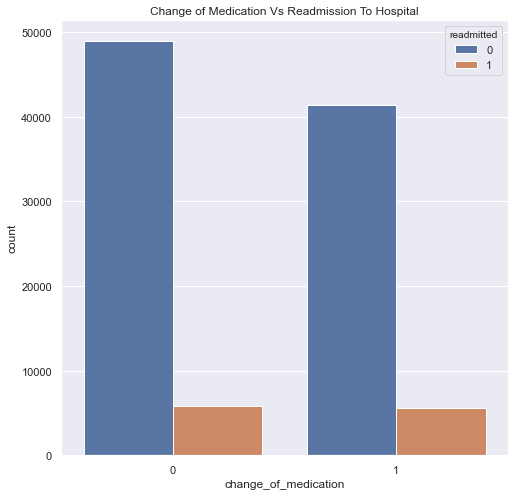

In [28]:
# Change of Medication Vs Readmission To Hospital
fig = plt.figure(figsize=(8,8))
sns.countplot(df1['change_of_medication'], hue = df1['readmitted']).set_title('Change of Medication Vs Readmission To Hospital')

Text(0.5, 1.0, 'Medication Vs Readmission To Hospital')

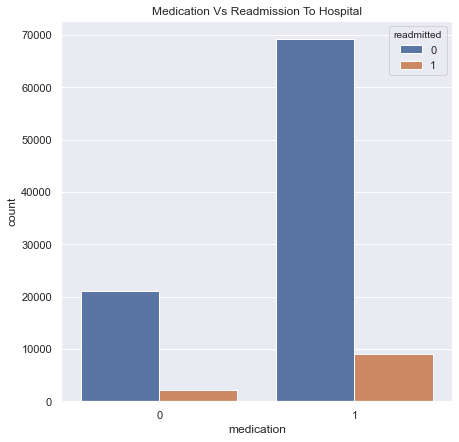

In [29]:
# Medication Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(df1['medication'], hue = df1['readmitted']).set_title('Medication Vs Readmission To Hospital')

Text(0.5, 1.0, 'Glucose Test Serum Result Vs Readmission To Hospital')

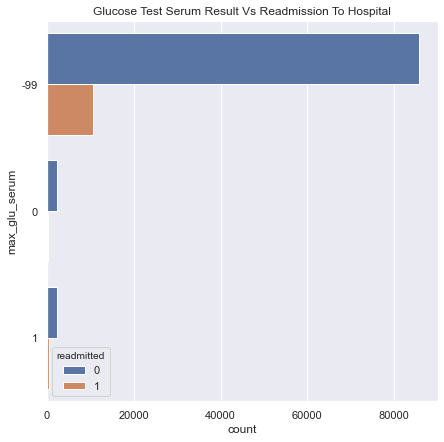

In [30]:
# Glucose Test Serum Result Vs Readmission To Hospital
# >200:1 = indicates diabetes, >300:1 = Indicates diabetes, Norm:0 = Normal, None:-99 = Test was not Taken / Other Issues
fig = plt.figure(figsize=(7,7))
sns.countplot(y = df1['max_glu_serum'], hue = df1['readmitted']).set_title('Glucose Test Serum Result Vs Readmission To Hospital')

Text(0.5, 1.0, 'A1C Test Result Vs Readmission To Hospital')

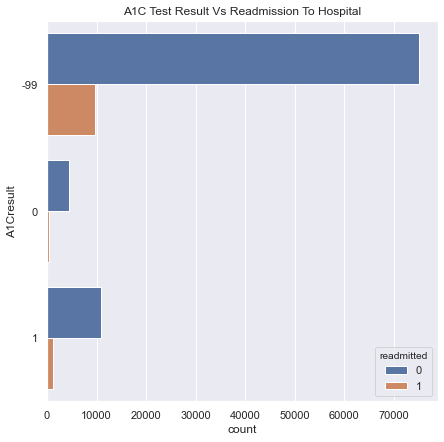

In [31]:
# A1C Test Result Vs Readmission To Hospital
# >7:1, >8:1, Norm:0, None:-99 = Test was not Taken / Other Issues
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['A1Cresult'], hue = df1['readmitted']).set_title('A1C Test Result Vs Readmission To Hospital')

Text(0.5, 1.0, 'Number of Lab Procedures Vs Readmission To Hospital')

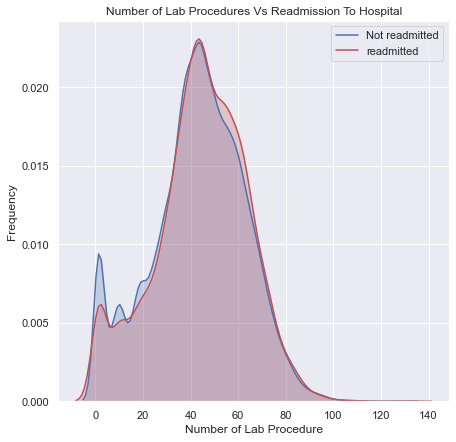

In [32]:
# Number of Lab Procedures Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7),)
ax=sns.kdeplot(df1.loc[(df1['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(df1.loc[(df1['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of Lab Procedure', ylabel='Frequency')
plt.title('Number of Lab Procedures Vs Readmission To Hospital')

Text(0.5, 1.0, 'Number of Lab Medications Vs Readmission To Hospital')

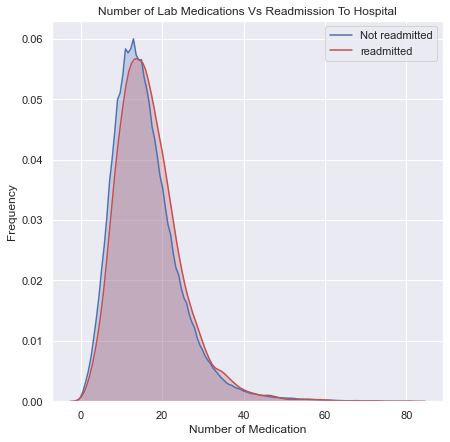

In [33]:
# Number of Lab Medications Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7),)
ax=sns.kdeplot(df1.loc[(df1['readmitted'] == 0),'num_medications'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(df1.loc[(df1['readmitted'] == 1),'num_medications'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of Medication', ylabel='Frequency')
plt.title('Number of Lab Medications Vs Readmission To Hospital')

Text(0.5, 1.0, 'Admission Type Vs Readmission To Hospital')

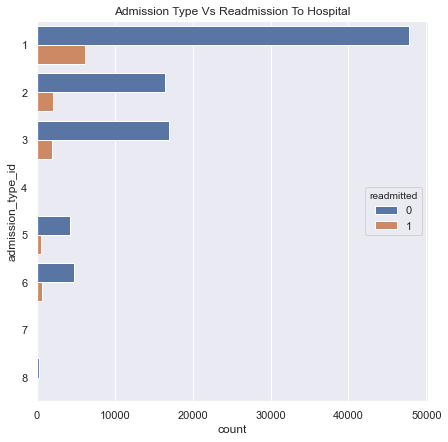

In [34]:
# Admission Type Vs Readmission To Hospital 
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['admission_type_id'], hue = df1['readmitted']).set_title('Admission Type Vs Readmission To Hospital')

Text(0.5, 1.0, 'Discharge Disposition Type Vs Readmission To Hospital')

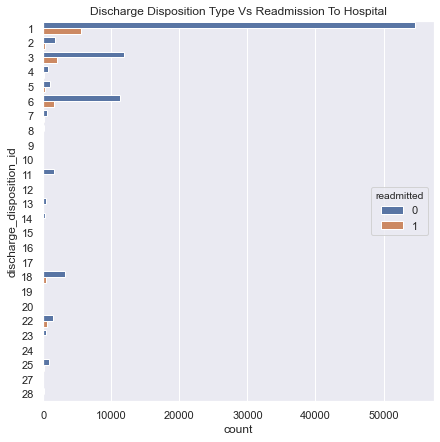

In [35]:
# Discharge Disposition Type Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['discharge_disposition_id'], hue = df1['readmitted']).set_title('Discharge Disposition Type Vs Readmission To Hospital')

Text(0.5, 1.0, 'Admission Source Type Vs Readmission To Hospital')

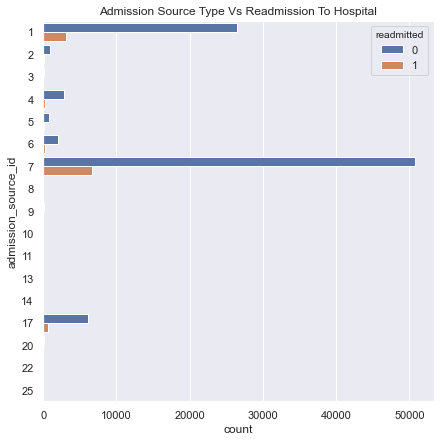

In [36]:
# Admission Source Type Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['admission_source_id'], hue = df1['readmitted']).set_title('Admission Source Type Vs Readmission To Hospital')

Text(0.5, 1.0, 'Procedures Vs Readmission To Hospital')

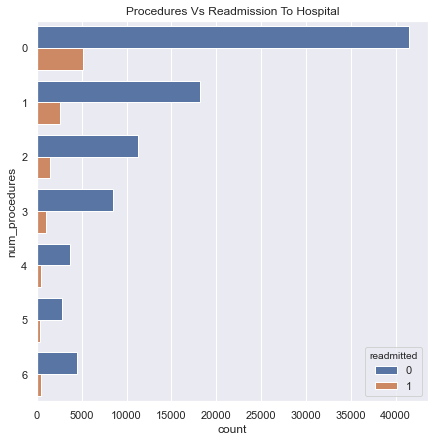

In [37]:
# Procedures Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['num_procedures'], hue = df1['readmitted']).set_title('Procedures Vs Readmission To Hospital')

Text(0.5, 1.0, 'Outpatient Vs Readmission To Hospital')

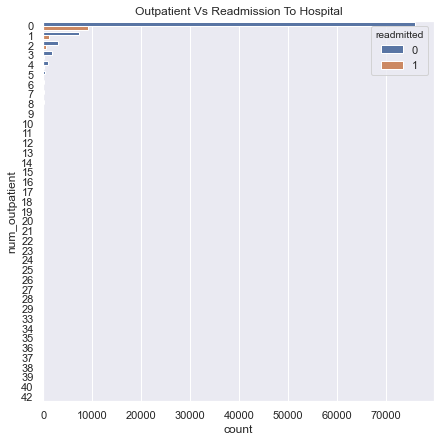

In [38]:
# Outpatient Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['num_outpatient'], hue = df1['readmitted']).set_title('Outpatient Vs Readmission To Hospital')

Text(0.5, 1.0, 'Emergency Vs Readmission To Hospital')

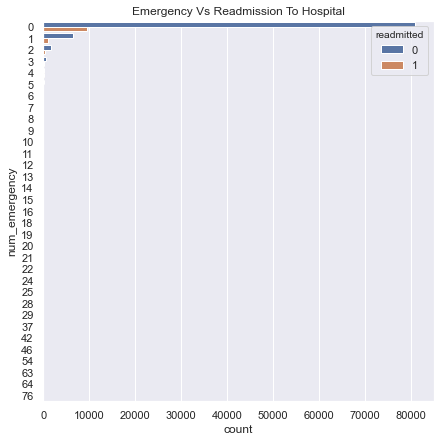

In [39]:
# Emergency Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['num_emergency'], hue = df1['readmitted']).set_title('Emergency Vs Readmission To Hospital')

Text(0.5, 1.0, 'Inpatient Vs Readmission To Hospital')

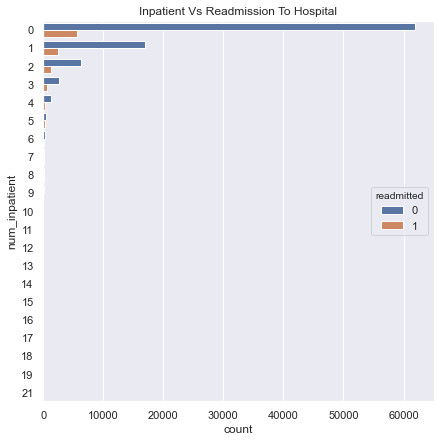

In [40]:
# Inpatient Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['num_inpatient'], hue = df1['readmitted']).set_title('Inpatient Vs Readmission To Hospital')

Text(0.5, 1.0, 'Diagnosis_1 Vs Readmission To Hospital')

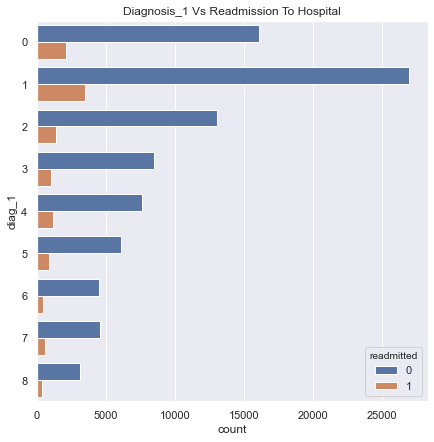

In [41]:
# Diagnosis_1 Vs Readmission To Hospital 
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['diag_1'], hue = df1['readmitted']).set_title('Diagnosis_1 Vs Readmission To Hospital')

Text(0.5, 1.0, 'Diagnosis_2 Vs Readmission To Hospital')

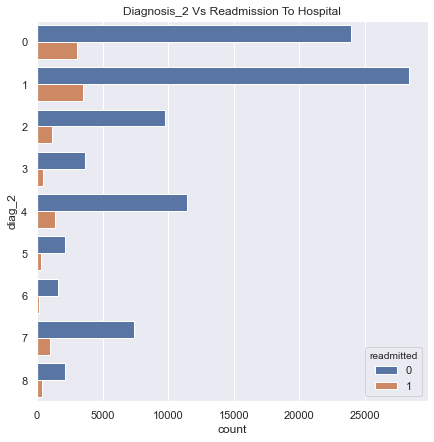

In [42]:
# Diagnosis_2 Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['diag_2'], hue = df1['readmitted']).set_title('Diagnosis_2 Vs Readmission To Hospital')

Text(0.5, 1.0, 'Diagnosis_3 Vs Readmission To Hospital')

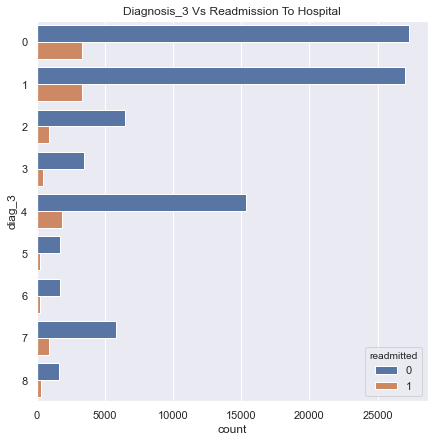

In [43]:
# Diagnosis_3 Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['diag_3'], hue = df1['readmitted']).set_title('Diagnosis_3 Vs Readmission To Hospital')

Text(0.5, 1.0, 'Diagnosis Vs Readmission To Hospital')

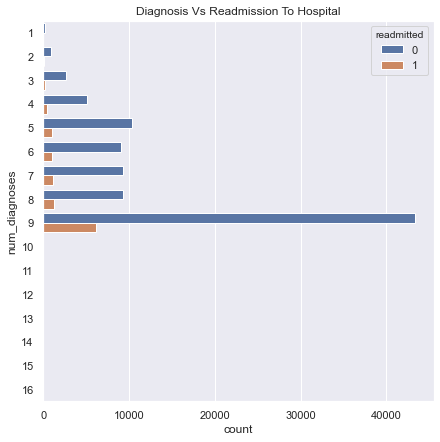

In [44]:
# Diagnosis Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['num_diagnoses'], hue = df1['readmitted']).set_title('Diagnosis Vs Readmission To Hospital')

Text(0.5, 1.0, 'Metformin Vs Readmission To Hospital')

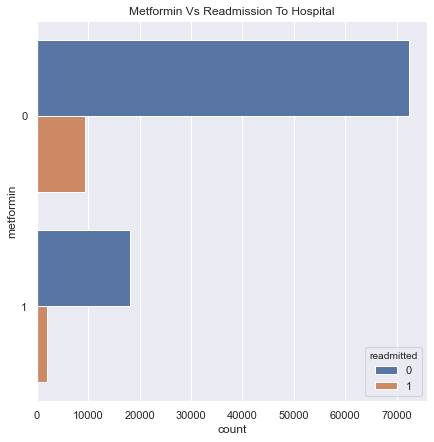

In [45]:
# Metformin Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['metformin'], hue = df1['readmitted']).set_title('Metformin Vs Readmission To Hospital')

Text(0.5, 1.0, 'Repaglinide Vs Readmission To Hospital')

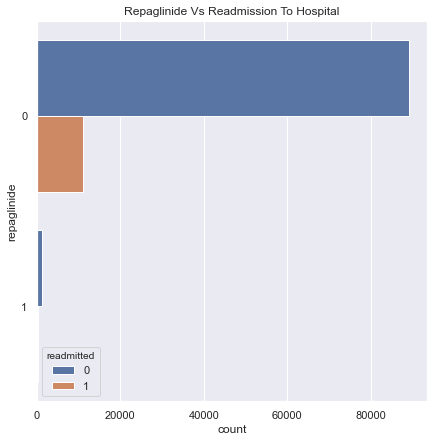

In [46]:
# Repaglinide Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['repaglinide'], hue = df1['readmitted']).set_title('Repaglinide Vs Readmission To Hospital')

Text(0.5, 1.0, 'Nateglinide Vs Readmission To Hospital')

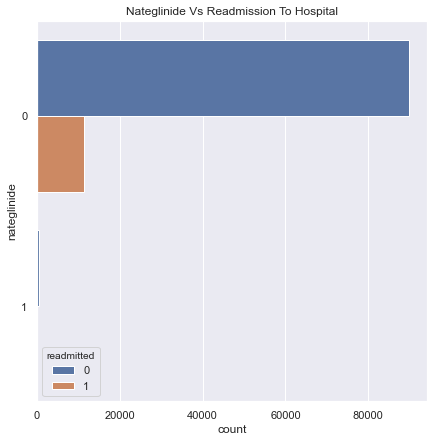

In [47]:
# Nateglinide Vs Readmission To Hospital'
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['nateglinide'], hue = df1['readmitted']).set_title('Nateglinide Vs Readmission To Hospital')

Text(0.5, 1.0, 'Chlorpropamide Vs Readmission To Hospital')

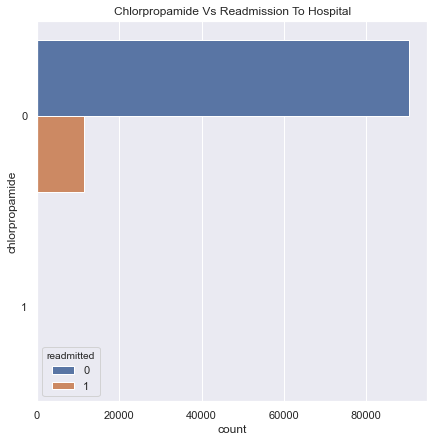

In [48]:
# Chlorpropamide Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['chlorpropamide'], hue = df1['readmitted']).set_title('Chlorpropamide Vs Readmission To Hospital')

Text(0.5, 1.0, 'Glimepiride Vs Readmission To Hospital')

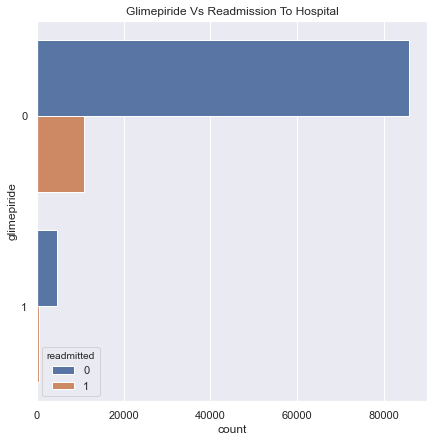

In [49]:
# Glimepiride Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['glimepiride'], hue = df1['readmitted']).set_title('Glimepiride Vs Readmission To Hospital')

Text(0.5, 1.0, 'Acetohexamide Vs Readmission To Hospital')

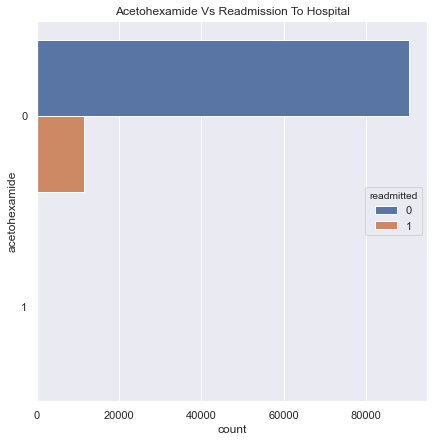

In [50]:
# Acetohexamide Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['acetohexamide'], hue = df1['readmitted']).set_title('Acetohexamide Vs Readmission To Hospital')

Text(0.5, 1.0, 'Glipizide Vs Readmission To Hospital')

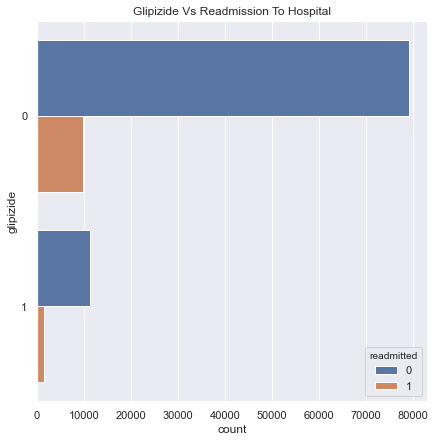

In [51]:
# Glipizide Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['glipizide'], hue = df1['readmitted']).set_title('Glipizide Vs Readmission To Hospital')

Text(0.5, 1.0, 'Glyburide Vs Readmission To Hospital')

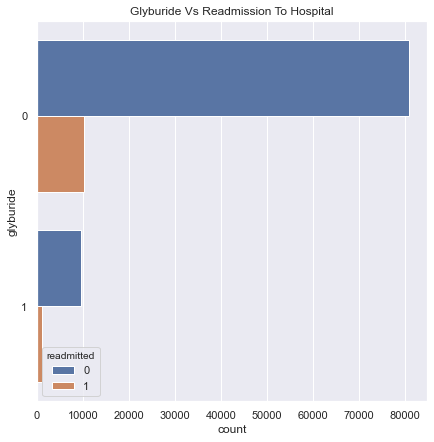

In [52]:
# Glyburide Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['glyburide'], hue = df1['readmitted']).set_title('Glyburide Vs Readmission To Hospital')

Text(0.5, 1.0, 'Tolbutamide Vs Readmission To Hospital')

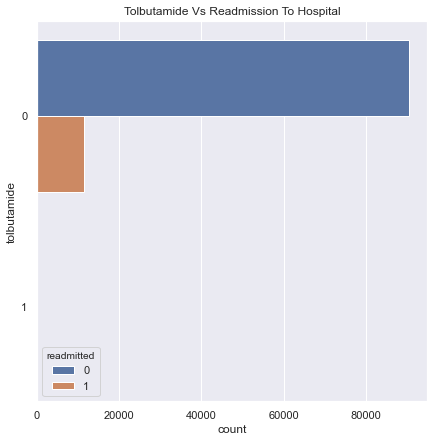

In [53]:
# Tolbutamide Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['tolbutamide'], hue = df1['readmitted']).set_title('Tolbutamide Vs Readmission To Hospital')

Text(0.5, 1.0, 'Pioglitazone Vs Readmission To Hospital')

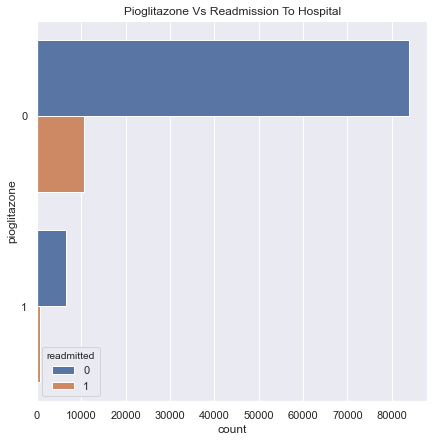

In [54]:
# Pioglitazone Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['pioglitazone'], hue = df1['readmitted']).set_title('Pioglitazone Vs Readmission To Hospital')

Text(0.5, 1.0, 'Rosiglitazone Vs Readmission To Hospital')

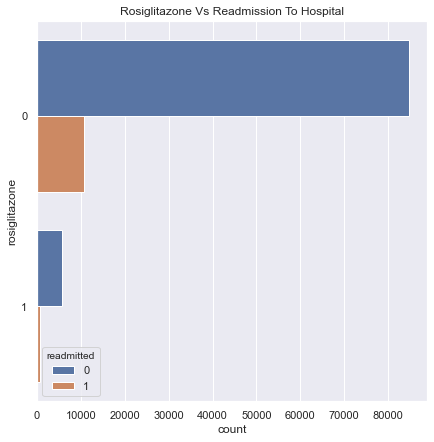

In [55]:
# Rosiglitazone Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['rosiglitazone'], hue = df1['readmitted']).set_title('Rosiglitazone Vs Readmission To Hospital')

Text(0.5, 1.0, 'Acarbose Vs Readmission To Hospital')

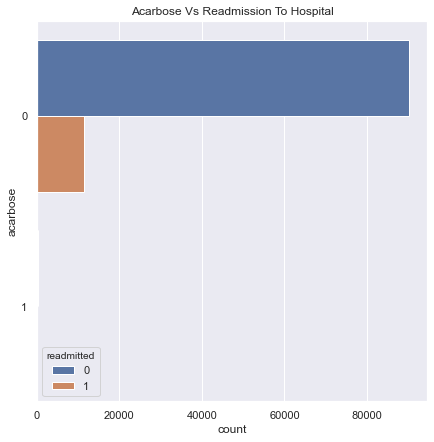

In [56]:
# Acarbose Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['acarbose'], hue = df1['readmitted']).set_title('Acarbose Vs Readmission To Hospital')

Text(0.5, 1.0, 'Miglitol Vs Readmission To Hospital')

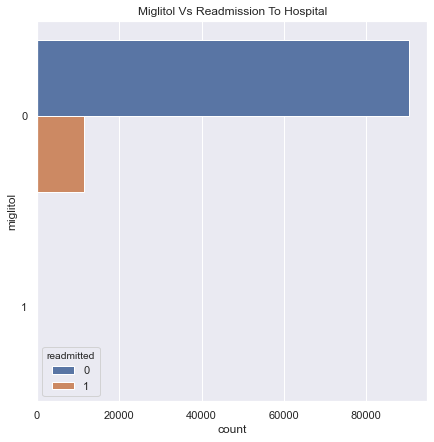

In [57]:
# Miglitol Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['miglitol'], hue = df1['readmitted']).set_title('Miglitol Vs Readmission To Hospital')

Text(0.5, 1.0, 'Troglitazone Vs Readmission To Hospital')

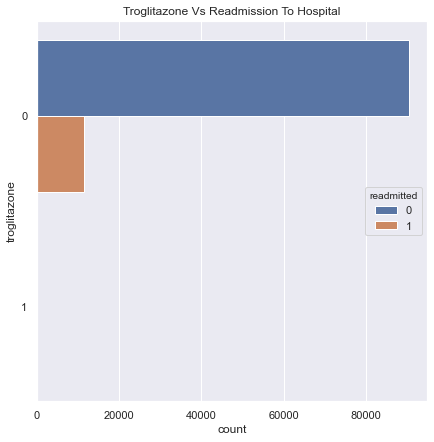

In [58]:
# Troglitazone Vs Readmission To Hospital 
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['troglitazone'], hue = df1['readmitted']).set_title('Troglitazone Vs Readmission To Hospital')

Text(0.5, 1.0, 'Tolazamide Vs Readmission To Hospital')

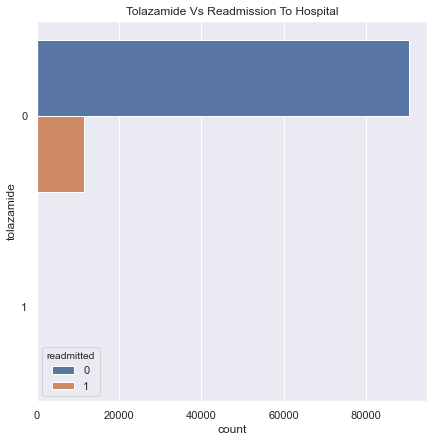

In [59]:
# Tolazamide Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['tolazamide'], hue = df1['readmitted']).set_title('Tolazamide Vs Readmission To Hospital')

Text(0.5, 1.0, 'Insulin Vs Readmission To Hospital')

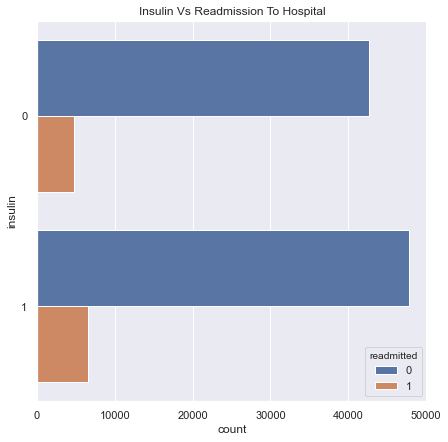

In [60]:
# Insulin Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['insulin'], hue = df1['readmitted']).set_title('Insulin Vs Readmission To Hospital')

Text(0.5, 1.0, 'Glyburide Metformin Vs Readmission To Hospital')

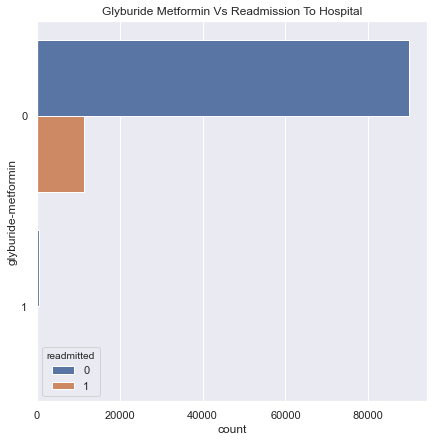

In [61]:
# Glyburide Metformin Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['glyburide-metformin'], hue = df1['readmitted']).set_title('Glyburide Metformin Vs Readmission To Hospital')

Text(0.5, 1.0, 'Glipizide Metformin Vs Readmission To Hospital')

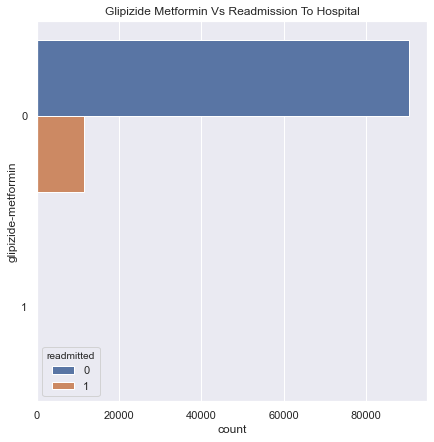

In [62]:
# Glipizide Metformin Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['glipizide-metformin'], hue = df1['readmitted']).set_title('Glipizide Metformin Vs Readmission To Hospital')

Text(0.5, 1.0, 'Glimepiride Pioglitazone Vs Readmission To Hospital')

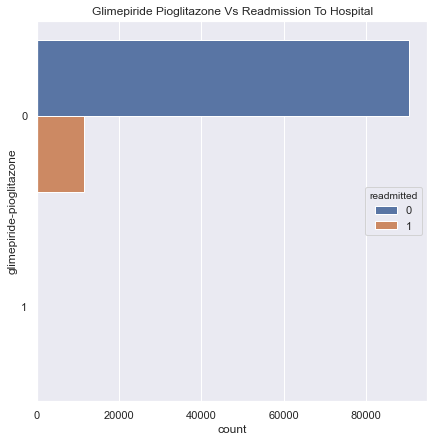

In [63]:
# Glimepiride Pioglitazone Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['glimepiride-pioglitazone'], hue = df1['readmitted']).set_title('Glimepiride Pioglitazone Vs Readmission To Hospital')

Text(0.5, 1.0, 'Metformin Rosiglitazone Vs Readmission To Hospital')

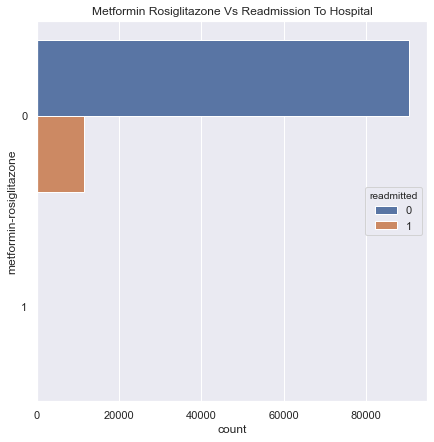

In [64]:
# Metformin Rosiglitazone Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['metformin-rosiglitazone'], hue = df1['readmitted']).set_title('Metformin Rosiglitazone Vs Readmission To Hospital')

Text(0.5, 1.0, 'Metformin Pioglitazone Vs Readmission To Hospital')

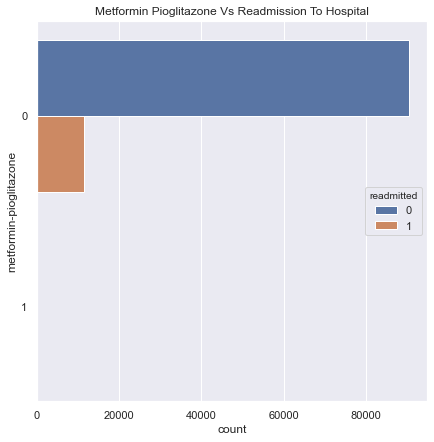

In [65]:
# Metformin Pioglitazone Vs Readmission To Hospital
fig = plt.figure(figsize=(7,7))
sns.countplot(y= df1['metformin-pioglitazone'], hue = df1['readmitted']).set_title('Metformin Pioglitazone Vs Readmission To Hospital')

#### Feature Engineering

In [66]:
one_hot_data = pd.get_dummies(df1, columns=['race'], prefix=["enc"])
one_hot_data = pd.get_dummies(one_hot_data)

In [67]:
df1 = one_hot_data.copy()
X = df1.drop(columns=['readmitted','patient_ID'], axis=1)
y = df1.readmitted

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 7)

#### SMOTE for Unbalanced Target

In [69]:
ros = SMOTE(sampling_strategy='all',random_state=7,k_neighbors=5,n_jobs=4)

In [70]:
X_res, y_res = ros.fit_resample(X,y)

In [71]:
X.shape,y.shape

((101766, 47), (101766,))

In [72]:
X_res.shape,y_res.shape

((180818, 47), (180818,))

#### Models Logistic Regression, KNN, Gradient Boosting Classifier, XGBoost Classifier, CatBoost Classifier, LightGBM Classifier

In [73]:
train_input_new = pd.DataFrame(X_res, columns = list(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=7)

In [74]:
#Logistic Regression
m1=LogisticRegression()
m1.fit(X_train,y_train)
y_pred_lr=m1.predict(X_test)
Train_Score_lr = m1.score(X_train,y_train)
Test_Score_lr = accuracy_score(y_test,y_pred_lr)
print('Training Accuracy is:',Train_Score_lr)
print('Testing Accuracy is:',Test_Score_lr)
print(classification_report(y_test,y_pred_lr))

Training Accuracy is: 0.7177264368769616
Testing Accuracy is: 0.7152693286140913
              precision    recall  f1-score   support

           0       0.72      0.71      0.71     18091
           1       0.71      0.73      0.72     18073

    accuracy                           0.72     36164
   macro avg       0.72      0.72      0.72     36164
weighted avg       0.72      0.72      0.72     36164



In [75]:
#KNN
m2 = KNeighborsClassifier()
m2.fit(X_train,y_train)
y_pred_knn = m2.predict(X_test)
Train_Score_knn = m2.score(X_train,y_train)
Test_Score_knn = accuracy_score(y_test,y_pred_knn)
print('Training Accuracy is :',Train_Score_knn)
print('Testing Accuracy is:',Test_Score_knn)
print('ROC AUC Score is:')
print(classification_report(y_test,y_pred_knn))

Training Accuracy is : 0.8608472631244211
Testing Accuracy is: 0.8077922796150868
ROC AUC Score is:
              precision    recall  f1-score   support

           0       0.99      0.62      0.76     18091
           1       0.72      0.99      0.84     18073

    accuracy                           0.81     36164
   macro avg       0.86      0.81      0.80     36164
weighted avg       0.86      0.81      0.80     36164



In [76]:
#Gradient Boosting Classifier
m3 = GradientBoostingClassifier(random_state=7)
m3.fit(X_train, y_train)
y_pred_gbc = m3.predict(X_test)
Train_Score_gbc = m3.score(X_train,y_train)
Test_Score_gbc = accuracy_score(y_test,y_pred_gbc)
print('Training Accuracy is :',Train_Score_gbc)
print('Testing Accuracy is:',Test_Score_gbc)
print(classification_report(y_test,y_pred_gbc))

Training Accuracy is : 0.7936455265668423
Testing Accuracy is: 0.7899015595619954
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     18091
           1       0.81      0.76      0.78     18073

    accuracy                           0.79     36164
   macro avg       0.79      0.79      0.79     36164
weighted avg       0.79      0.79      0.79     36164



In [77]:
#XGBoost Classifier
m4 = XGBClassifier(random_state=7, n_jobs=-1,max_depth=3)
m4.fit(X_train, y_train)
y_pred_xgb = m4.predict(X_test)
Train_Score_xgb = m4.score(X_train,y_train)
Test_Score_xgb = accuracy_score(y_test,y_pred_xgb)
print('Training Accuracy is :',Train_Score_xgb)
print('Testing Accuracy is:',Test_Score_xgb)
print(classification_report(y_test,y_pred_xgb))

[13:12:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy is : 0.818912715859914
Testing Accuracy is: 0.8130737750248866
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     18091
           1       0.83      0.78      0.81     18073

    accuracy                           0.81     36164
   macro avg       0.81      0.81      0.81     36164
weighted avg       0.81      0.81      0.81     36164



In [78]:
#CatBoost Classifier
m5 = CatBoostClassifier(random_state=7,max_depth=3)
m5.fit(X_train, y_train)
y_pred_cb = m4.predict(X_test)
Train_Score_cb = m5.score(X_train,y_train)
Test_Score_cb = accuracy_score(y_test,y_pred_cb)
print('Training Accuracy is :',Train_Score_cb)
print('Testing Accuracy is:',Test_Score_cb)
print(classification_report(y_test,y_pred_cb))

Learning rate set to 0.086178
0:	learn: 0.6819632	total: 214ms	remaining: 3m 33s
1:	learn: 0.6727278	total: 239ms	remaining: 1m 59s
2:	learn: 0.6654160	total: 260ms	remaining: 1m 26s
3:	learn: 0.6589499	total: 282ms	remaining: 1m 10s
4:	learn: 0.6528661	total: 306ms	remaining: 1m
5:	learn: 0.6410765	total: 329ms	remaining: 54.5s
6:	learn: 0.6361546	total: 351ms	remaining: 49.8s
7:	learn: 0.6269177	total: 375ms	remaining: 46.5s
8:	learn: 0.6225865	total: 398ms	remaining: 43.8s
9:	learn: 0.6181850	total: 433ms	remaining: 42.8s
10:	learn: 0.6145987	total: 458ms	remaining: 41.2s
11:	learn: 0.6109391	total: 486ms	remaining: 40s
12:	learn: 0.6033630	total: 509ms	remaining: 38.7s
13:	learn: 0.6003703	total: 538ms	remaining: 37.9s
14:	learn: 0.5974780	total: 566ms	remaining: 37.2s
15:	learn: 0.5947698	total: 591ms	remaining: 36.4s
16:	learn: 0.5888444	total: 627ms	remaining: 36.3s
17:	learn: 0.5863585	total: 654ms	remaining: 35.7s
18:	learn: 0.5841901	total: 677ms	remaining: 35s
19:	learn: 0.5

161:	learn: 0.4593065	total: 5.21s	remaining: 26.9s
162:	learn: 0.4588540	total: 5.24s	remaining: 26.9s
163:	learn: 0.4585975	total: 5.27s	remaining: 26.9s
164:	learn: 0.4582998	total: 5.3s	remaining: 26.8s
165:	learn: 0.4580700	total: 5.33s	remaining: 26.8s
166:	learn: 0.4578691	total: 5.36s	remaining: 26.7s
167:	learn: 0.4576296	total: 5.39s	remaining: 26.7s
168:	learn: 0.4573907	total: 5.42s	remaining: 26.6s
169:	learn: 0.4570779	total: 5.45s	remaining: 26.6s
170:	learn: 0.4566043	total: 5.47s	remaining: 26.5s
171:	learn: 0.4564018	total: 5.5s	remaining: 26.5s
172:	learn: 0.4561904	total: 5.53s	remaining: 26.4s
173:	learn: 0.4559576	total: 5.56s	remaining: 26.4s
174:	learn: 0.4557469	total: 5.59s	remaining: 26.4s
175:	learn: 0.4555261	total: 5.62s	remaining: 26.3s
176:	learn: 0.4551721	total: 5.65s	remaining: 26.3s
177:	learn: 0.4546476	total: 5.68s	remaining: 26.2s
178:	learn: 0.4543786	total: 5.71s	remaining: 26.2s
179:	learn: 0.4541642	total: 5.73s	remaining: 26.1s
180:	learn: 0.

320:	learn: 0.4260989	total: 10.5s	remaining: 22.1s
321:	learn: 0.4260276	total: 10.5s	remaining: 22.1s
322:	learn: 0.4259088	total: 10.5s	remaining: 22.1s
323:	learn: 0.4258123	total: 10.6s	remaining: 22.1s
324:	learn: 0.4257001	total: 10.6s	remaining: 22.1s
325:	learn: 0.4255745	total: 10.7s	remaining: 22s
326:	learn: 0.4254832	total: 10.7s	remaining: 22s
327:	learn: 0.4252467	total: 10.7s	remaining: 22s
328:	learn: 0.4250127	total: 10.8s	remaining: 21.9s
329:	learn: 0.4249222	total: 10.8s	remaining: 21.9s
330:	learn: 0.4248325	total: 10.8s	remaining: 21.9s
331:	learn: 0.4247131	total: 10.9s	remaining: 21.9s
332:	learn: 0.4246474	total: 10.9s	remaining: 21.9s
333:	learn: 0.4245327	total: 10.9s	remaining: 21.8s
334:	learn: 0.4243668	total: 11s	remaining: 21.8s
335:	learn: 0.4240931	total: 11s	remaining: 21.8s
336:	learn: 0.4239954	total: 11.1s	remaining: 21.7s
337:	learn: 0.4238644	total: 11.1s	remaining: 21.7s
338:	learn: 0.4237793	total: 11.1s	remaining: 21.7s
339:	learn: 0.4236374	

480:	learn: 0.4101859	total: 16.8s	remaining: 18.1s
481:	learn: 0.4100669	total: 16.8s	remaining: 18.1s
482:	learn: 0.4100161	total: 16.9s	remaining: 18s
483:	learn: 0.4099633	total: 16.9s	remaining: 18s
484:	learn: 0.4098088	total: 17s	remaining: 18s
485:	learn: 0.4097553	total: 17s	remaining: 18s
486:	learn: 0.4096969	total: 17.1s	remaining: 18s
487:	learn: 0.4096364	total: 17.1s	remaining: 18s
488:	learn: 0.4095879	total: 17.2s	remaining: 18s
489:	learn: 0.4095353	total: 17.2s	remaining: 17.9s
490:	learn: 0.4094734	total: 17.3s	remaining: 17.9s
491:	learn: 0.4092924	total: 17.3s	remaining: 17.9s
492:	learn: 0.4092359	total: 17.4s	remaining: 17.9s
493:	learn: 0.4091656	total: 17.4s	remaining: 17.8s
494:	learn: 0.4091220	total: 17.5s	remaining: 17.8s
495:	learn: 0.4090348	total: 17.5s	remaining: 17.8s
496:	learn: 0.4089471	total: 17.6s	remaining: 17.8s
497:	learn: 0.4088825	total: 17.6s	remaining: 17.8s
498:	learn: 0.4088349	total: 17.7s	remaining: 17.7s
499:	learn: 0.4087646	total: 1

642:	learn: 0.3994818	total: 22.8s	remaining: 12.7s
643:	learn: 0.3994484	total: 22.9s	remaining: 12.6s
644:	learn: 0.3991950	total: 22.9s	remaining: 12.6s
645:	learn: 0.3991543	total: 23s	remaining: 12.6s
646:	learn: 0.3991132	total: 23s	remaining: 12.5s
647:	learn: 0.3990720	total: 23s	remaining: 12.5s
648:	learn: 0.3990283	total: 23.1s	remaining: 12.5s
649:	learn: 0.3989259	total: 23.1s	remaining: 12.4s
650:	learn: 0.3988856	total: 23.1s	remaining: 12.4s
651:	learn: 0.3988493	total: 23.2s	remaining: 12.4s
652:	learn: 0.3988189	total: 23.2s	remaining: 12.3s
653:	learn: 0.3987469	total: 23.2s	remaining: 12.3s
654:	learn: 0.3986971	total: 23.3s	remaining: 12.3s
655:	learn: 0.3986666	total: 23.3s	remaining: 12.2s
656:	learn: 0.3986337	total: 23.3s	remaining: 12.2s
657:	learn: 0.3986021	total: 23.4s	remaining: 12.1s
658:	learn: 0.3985371	total: 23.4s	remaining: 12.1s
659:	learn: 0.3985050	total: 23.4s	remaining: 12.1s
660:	learn: 0.3984021	total: 23.5s	remaining: 12s
661:	learn: 0.398356

804:	learn: 0.3924785	total: 28.4s	remaining: 6.89s
805:	learn: 0.3924185	total: 28.5s	remaining: 6.85s
806:	learn: 0.3923904	total: 28.5s	remaining: 6.82s
807:	learn: 0.3923632	total: 28.5s	remaining: 6.78s
808:	learn: 0.3923344	total: 28.6s	remaining: 6.74s
809:	learn: 0.3923186	total: 28.6s	remaining: 6.71s
810:	learn: 0.3922763	total: 28.6s	remaining: 6.67s
811:	learn: 0.3922657	total: 28.7s	remaining: 6.64s
812:	learn: 0.3922228	total: 28.7s	remaining: 6.6s
813:	learn: 0.3921928	total: 28.7s	remaining: 6.56s
814:	learn: 0.3921560	total: 28.8s	remaining: 6.53s
815:	learn: 0.3921260	total: 28.8s	remaining: 6.49s
816:	learn: 0.3920880	total: 28.8s	remaining: 6.45s
817:	learn: 0.3920510	total: 28.8s	remaining: 6.42s
818:	learn: 0.3920221	total: 28.9s	remaining: 6.38s
819:	learn: 0.3919984	total: 28.9s	remaining: 6.34s
820:	learn: 0.3919551	total: 28.9s	remaining: 6.31s
821:	learn: 0.3919226	total: 29s	remaining: 6.27s
822:	learn: 0.3918846	total: 29s	remaining: 6.24s
823:	learn: 0.391

963:	learn: 0.3874017	total: 33.5s	remaining: 1.25s
964:	learn: 0.3873843	total: 33.5s	remaining: 1.22s
965:	learn: 0.3873620	total: 33.5s	remaining: 1.18s
966:	learn: 0.3873367	total: 33.6s	remaining: 1.15s
967:	learn: 0.3873096	total: 33.6s	remaining: 1.11s
968:	learn: 0.3872901	total: 33.6s	remaining: 1.07s
969:	learn: 0.3872638	total: 33.7s	remaining: 1.04s
970:	learn: 0.3872381	total: 33.7s	remaining: 1.01s
971:	learn: 0.3872081	total: 33.7s	remaining: 971ms
972:	learn: 0.3871746	total: 33.8s	remaining: 937ms
973:	learn: 0.3871557	total: 33.8s	remaining: 902ms
974:	learn: 0.3871338	total: 33.8s	remaining: 867ms
975:	learn: 0.3870832	total: 33.9s	remaining: 833ms
976:	learn: 0.3870026	total: 33.9s	remaining: 798ms
977:	learn: 0.3870005	total: 33.9s	remaining: 763ms
978:	learn: 0.3869699	total: 34s	remaining: 729ms
979:	learn: 0.3869488	total: 34s	remaining: 694ms
980:	learn: 0.3869154	total: 34s	remaining: 659ms
981:	learn: 0.3868774	total: 34.1s	remaining: 624ms
982:	learn: 0.3868

In [79]:
#LightGBM Classifier
m6 = LGBMClassifier(random_state=7,max_depth=3)
m6.fit(X_train, y_train)
y_pred_lgbm = m6.predict(X_test)
Train_Score_lgbm = m6.score(X_train,y_train)
Test_Score_lgbm = accuracy_score(y_test,y_pred_lgbm)
print('Training Accuracy is :',Train_Score_lgbm)
print('Testing Accuracy is:',Test_Score_lgbm)
print(classification_report(y_test,y_pred_lgbm))

Training Accuracy is : 0.7929127435121047
Testing Accuracy is: 0.7889060944585776
              precision    recall  f1-score   support

           0       0.77      0.82      0.79     18091
           1       0.80      0.76      0.78     18073

    accuracy                           0.79     36164
   macro avg       0.79      0.79      0.79     36164
weighted avg       0.79      0.79      0.79     36164



#### Hyperparameter Optimization with LightGBM Classifier Model

In [80]:
random_grid = {
             'boosting_type': ['gbdt','dart','goss','rf'],
             'num_leaves':list(range(1,50,1)),
             'n_estimators':list(range(100,300)),
             'max_depth':list(range(-1,30,1)),
             }

# LightGBM model
final_lgbm = LGBMClassifier(n_jobs=-1,random_state=7)

In [81]:
# randommized searchCV
lgbm = RandomizedSearchCV(final_lgbm,random_grid,cv=5,scoring="f1")
lgbm.fit(X_train,y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(random_state=7),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss', 'rf'],
                                        'max_depth': [-1, 0, 1, 2, 3, 4, 5, 6,
                                                      7, 8, 9, 10, 11, 12, 13,
                                                      14, 15, 16, 17, 18, 19,
                                                      20, 21, 22, 23, 24, 25,
                                                      26, 27, 28, ...],
                                        'n_estimators': [100, 101, 102, 103,
                                                         104, 105, 106, 107,
                                                         108, 109, 110, 111,
                                                         112, 113, 114, 115,
                                                         116, 117, 118, 119,
               

In [82]:
# obtian best parameters best score
lgbm.best_score_,lgbm.best_params_,lgbm.best_estimator_

(0.8405294671886143,
 {'num_leaves': 49,
  'n_estimators': 257,
  'max_depth': 14,
  'boosting_type': 'goss'},
 LGBMClassifier(boosting_type='goss', max_depth=14, n_estimators=257,
                num_leaves=49, random_state=7))

In [83]:
# use the best params
lgbm = LGBMClassifier(boosting_type=lgbm.best_params_['boosting_type'],
                           num_leaves=lgbm.best_params_['num_leaves'], 
                           n_estimators=lgbm.best_params_['n_estimators'],
                           max_depth=lgbm.best_params_['max_depth'],
                           n_jobs=-1,  random_state=7)
lgbm.fit(X_train,y_train)
y_pred_lgbm = lgbm.predict(X_test)
Train_Score_lgbm = lgbm.score(X_train,y_train)
Test_Score_lgbm = accuracy_score(y_test,y_pred_lgbm)
print('Training Accuracy is :',Train_Score_lgbm)
print('Testing Accuracy is:',Test_Score_lgbm)
print(classification_report(y_test,y_pred_lgbm))#

Training Accuracy is : 0.865921440126094
Testing Accuracy is: 0.8475002765180842
              precision    recall  f1-score   support

           0       0.82      0.89      0.85     18091
           1       0.88      0.81      0.84     18073

    accuracy                           0.85     36164
   macro avg       0.85      0.85      0.85     36164
weighted avg       0.85      0.85      0.85     36164



#### Feature Selection baed on Parameters

In [84]:
#Fearture Importance LightGBM 
feature_imp = pd.Series(lgbm.feature_importances_, index = X_train.columns)
best_features = feature_imp.nlargest()
print(best_features)

num_lab_procedures          1515
num_medications             1221
discharge_disposition_id     795
diag_1                       728
time_in_hospital             686
dtype: int32


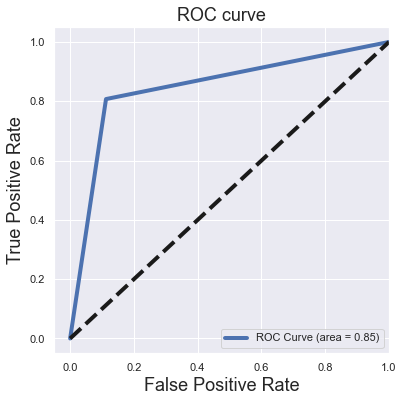

In [85]:
# obtian the preditions
X_train_pre = lgbm.predict(X_train)
X_test_pre = lgbm.predict(X_test)
fpr, tpr, threshold = roc_curve(y_test, X_test_pre)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()